In [1]:
! cd /content/drive/My\ Drive/CS182\ Final\ Project:\ Computer\ Vision/spatial-pytorch

/bin/bash: line 0: cd: /content/drive/My Drive/CS182 Final Project: Computer Vision/spatial-pytorch: No such file or directory


In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def accuracy(output, target, topk=(1,), exact=False):
    """
        Computes the top-k accuracy for the specified values of k
        Args:
            output (ch.tensor) : model output (N, classes) or (N, attributes) 
                for sigmoid/multitask binary classification
            target (ch.tensor) : correct labels (N,) [multiclass] or (N,
                attributes) [multitask binary]
            topk (tuple) : for each item "k" in this tuple, this method
                will return the top-k accuracy
            exact (bool) : whether to return aggregate statistics (if
                False) or per-example correctness (if True)
        Returns:
            A list of top-k accuracies.
    """
    with torch.no_grad():
        # Binary Classification
        if len(target.shape) > 1:
            assert output.shape == target.shape, \
                "Detected binary classification but output shape != target shape"
            return [ch.round(ch.sigmoid(output)).eq(ch.round(target)).float().mean()], [-1.0] 

        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        res_exact = []
        for k in topk:
            correct_k = correct[:k].view(-1).float()
            ck_sum = correct_k.sum(0, keepdim=True)
            res.append(ck_sum.mul_(100.0 / batch_size))
            res_exact.append(correct_k)

        if not exact:
            return res
        else:
            return res_exact

In [0]:
!pip install robustness

In [0]:
import tqdm
import torch

In [0]:
import torch as ch
from robustness.datasets import CIFAR
from robustness.model_utils import make_and_restore_model

ds = CIFAR('/path/to/cifar')
model, _ = make_and_restore_model(arch='resnet18', dataset=ds,
             resume_path='/content/drive/My Drive/CS182 Final Project: Computer Vision/spatial-pytorch/models/worst10_40/checkpoint.pt.best')
model.eval()

In [0]:
train_loader, test_loader = ds.make_loaders(workers=0, batch_size=128)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
attack_kwargs = {
   'constraint': 'inf', # L-inf PGD
   'eps': 0.01, # Epsilon constraint (L-inf norm)
   'step_size': 0.01, # Learning rate for PGD
   'iterations': 10, # Number of PGD steps
   'targeted': False, # Targeted attack
   'custom_loss': None # Use default cross-entropy loss
}


In [0]:
top1 = AverageMeter()
iterator = tqdm.notebook.tqdm((train_loader))
for im, label in iterator:
    adv_out, adv_im = model(im, label, make_adv=True, **attack_kwargs)
    acc = accuracy(adv_out, label.cuda())[0].item()
    top1.update(acc, target_label.size(0))
    desc = ('Top 1 Acc: {top1.avg:.3f} |'.format(top1=top1))
    iterator.set_description(desc)
    iterator.refresh()

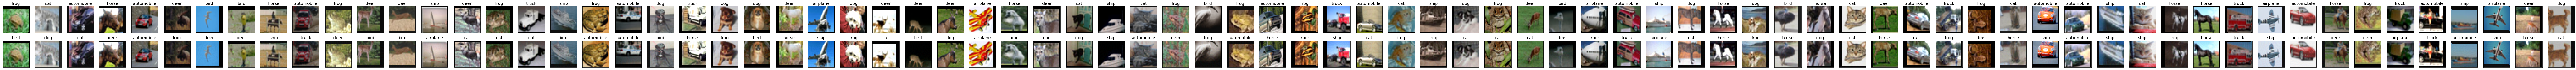

In [0]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT

# Get predicted labels for adversarial examples
pred, _ = model(adv_im)
label_pred = ch.argmax(pred, dim=1)

# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), adv_im.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CIFAR.png')